# DNSC 6290 Large Datasets Group Project

## Group 6——PUBG Match Deaths and Statistics

Create SparkContext and SparkSession:

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
     .appName("Test SparkSession") \
     .getOrCreate()

#Remember to close sc at the end

In [3]:
spark

Load packages.

In [ ]:
#pip install pyspark_dist_explore

In [4]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from pyspark_dist_explore import hist
import seaborn as sns
import matplotlib.cm as cm

import pyspark.sql.functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_auc_score, precision_score, recall_score 

### 1. Load and Prepare Data

We need to stack all five aggregate files into one file, as well as stacking all five deaths files into one. 

In [5]:
#This command read every file in the "aggregate" folder
aggr_all = spark.read.option("header", "true") \
    .option("delimiter", ",") \
    .option("inferSchema", "true") \
    .csv("s3://bigdata2020group6/aggregate/agg_match_stats_*.csv")

In [6]:
aggr_all.count() #67369236 rows in total

67369231

In [6]:
#This command read every file in the "deaths" folder
death_all = spark.read.option("header", "true") \
    .option("delimiter", ",") \
    .option("inferSchema", "true") \
    .csv("s3://bigdata2020group6/deaths/kill_match_stats_final_*.csv")

In [8]:
death_all.count() #65370475 rows in total

65370475

### 2. Explore Data Structure and Clean Data

In [9]:
aggr_all.show(10)

+--------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+-----------+-------------------+-------+--------------+
|                date|game_size|            match_id|match_mode|party_size|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|
+--------------------+---------+--------------------+----------+----------+--------------+-----------+------------------+------------------+----------+------------+-----------+-------------------+-------+--------------+
|2017-11-26T20:59:...|       37|2U4GBNA0YmnNZYkzj...|       tpp|         2|             0|          1|          2870.724|        1784.84778|       117|           1|   SnuffIes|            1106.32|      4|            18|
|2017-11-26T20:59:...|       37|2U4GBNA0YmnNZYkzj...|       tpp|         2|             0|          1|2938.4072300000003

In [10]:
death_all.show(10)

+------------+----------------+----------------+-----------------+-----------------+-------+--------------------+----+---------------+----------------+-----------------+-----------------+
|   killed_by|     killer_name|killer_placement|killer_position_x|killer_position_y|    map|            match_id|time|    victim_name|victim_placement|victim_position_x|victim_position_y|
+------------+----------------+----------------+-----------------+-----------------+-------+--------------------+----+---------------+----------------+-----------------+-----------------+
|     Grenade| KrazyPortuguese|             5.0|         657725.1|         146275.2|MIRAMAR|2U4GBNA0YmnLSqvEy...| 823|KrazyPortuguese|             5.0|         657725.1|         146275.2|
|      SCAR-L|nide2Bxiaojiejie|            31.0|         93091.37|         722236.4|MIRAMAR|2U4GBNA0YmnLSqvEy...| 194|    X3evolution|            33.0|         92238.68|         723375.1|
|        S686|        Ascholes|            43.0|         366

Check on the variable type for each column: 

In [11]:
death_all.printSchema

<bound method DataFrame.printSchema of DataFrame[killed_by: string, killer_name: string, killer_placement: double, killer_position_x: double, killer_position_y: double, map: string, match_id: string, time: int, victim_name: string, victim_placement: double, victim_position_x: double, victim_position_y: double]>

In [12]:
aggr_all.printSchema

<bound method DataFrame.printSchema of DataFrame[date: string, game_size: int, match_id: string, match_mode: string, party_size: int, player_assists: int, player_dbno: int, player_dist_ride: double, player_dist_walk: double, player_dmg: int, player_kills: int, player_name: string, player_survive_time: double, team_id: int, team_placement: int]>

Check NA in each column: 

In [13]:
aggr_all.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in aggr_all.columns]).show()

+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|date|game_size|match_id|match_mode|party_size|player_assists|player_dbno|player_dist_ride|player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|
+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|   0|        0|       0|         0|         0|             0|          0|               0|               0|         0|           0|      97653|                  0|      0|             0|
+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+



In [14]:
death_all.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in death_all.columns]).show()

+---------+-----------+----------------+-----------------+-----------------+------+--------+----+-----------+----------------+-----------------+-----------------+
|killed_by|killer_name|killer_placement|killer_position_x|killer_position_y|   map|match_id|time|victim_name|victim_placement|victim_position_x|victim_position_y|
+---------+-----------+----------------+-----------------+-----------------+------+--------+----+-----------+----------------+-----------------+-----------------+
|        0|    4517469|         4517469|          4517469|          4517469|783392|       0|   0|          0|         1227694|                0|                0|
+---------+-----------+----------------+-----------------+-----------------+------+--------+----+-----------+----------------+-----------------+-----------------+



Drop NA or Fill in Value for NA：

In [15]:
aggr_all = aggr_all.filter(aggr_all.player_name.isNotNull()) #drop rows with NA in player names

In [16]:
death_all = death_all.filter(death_all.map.isNotNull()) #drop rows with NA in map column

In [17]:
death_all = death_all.filter(death_all.victim_placement.isNotNull()) # drop rows with no victim placement

In [18]:
death_all = death_all.fillna({'killer_name':'NaN'}) #replace null values with NaN in killer name 

In [19]:
death_all = death_all.fillna({'killer_placement':'0'}) #replace null value with 0 in killer placement

In [20]:
death_all = death_all.fillna({'killer_position_x':'0'})  #replace null value with 0 in killer positions
death_all = death_all.fillna({'killer_position_y':'0'})

Check on NA values again in aggr_all: 

In [21]:
aggr_all.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in aggr_all.columns]).show()

+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|date|game_size|match_id|match_mode|party_size|player_assists|player_dbno|player_dist_ride|player_dist_walk|player_dmg|player_kills|player_name|player_survive_time|team_id|team_placement|
+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+
|   0|        0|       0|         0|         0|             0|          0|               0|               0|         0|           0|          0|                  0|      0|             0|
+----+---------+--------+----------+----------+--------------+-----------+----------------+----------------+----------+------------+-----------+-------------------+-------+--------------+



In [22]:
death_all.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in death_all.columns]).show()

+---------+-----------+----------------+-----------------+-----------------+---+--------+----+-----------+----------------+-----------------+-----------------+
|killed_by|killer_name|killer_placement|killer_position_x|killer_position_y|map|match_id|time|victim_name|victim_placement|victim_position_x|victim_position_y|
+---------+-----------+----------------+-----------------+-----------------+---+--------+----+-----------+----------------+-----------------+-----------------+
|        0|    4455678|               0|                0|                0|  0|       0|   0|          0|               0|                0|                0|
+---------+-----------+----------------+-----------------+-----------------+---+--------+----+-----------+----------------+-----------------+-----------------+



For killer position = 0, we let killer position = victim position:

In [23]:
death_all = death_all.withColumn('killer_position_x', \
                     F.when(death_all.killer_position_x == 0,death_all.victim_position_x).otherwise(death_all['killer_position_x']))
                     

In [24]:
death_all = death_all.withColumn('killer_position_y', \
                     F.when(death_all.killer_position_y == 0,death_all.victim_position_y).otherwise(death_all['killer_position_y']))
                     

For victim position = 0, we let victim position = killer position:

In [25]:
death_all = death_all.withColumn('victim_position_x', \
                     F.when(death_all.victim_position_x == 0,death_all.killer_position_x).otherwise(death_all['victim_position_x']))
    

In [26]:
death_all = death_all.withColumn('victim_position_y', \
                     F.when(death_all.victim_position_y == 0,death_all.killer_position_y).otherwise(death_all['victim_position_y']))
    

For case where both killer and victime position = 0, we drop these rows:

In [27]:
death_all = death_all.filter(death_all.victim_position_x != 0)

Make sure there is no zeroes in victim position and killer position: 

In [29]:
death_all.where(F.col("victim_position_x") == 0).count()

0

In [30]:
death_all.where(F.col("victim_position_y") == 0).count()

0

In [31]:
death_all.where(F.col("killer_position_x") == 0).count()

0

In [32]:
death_all.where(F.col("killer_position_y") == 0).count()

0

### 3. Analyze Data

Since the total number of parties varies, we split aggregate dateframe into three dfs based on party_size.   
For Party size =1, there are up to 100 parties in a game.   
For Party size =2, there are up to 50 parities in a game.  
For Party size = 4, tehre are up to 25 parties in a game.  

In [33]:
single = aggr_all.filter(F.col("party_size") == 1)
double = aggr_all.filter(F.col("party_size") == 2)
quadruple = aggr_all.filter(F.col("party_size") == 4)

#### (1) SQL:

##### a. Which locations is "dangerous" for parachuting? 

In [7]:
aggr_all.createOrReplaceTempView("aggr")
death_all.createOrReplaceTempView("death")  

First, we check the histogram of time to find the pattern of the death with time.

In [13]:
time_hist = death_all.select('time').rdd.flatMap(lambda x: x).histogram(10)

In [30]:
time_dist_df = pd.DataFrame(list(zip(time_hist[0],time_hist[1])),columns = ['time','freq'])

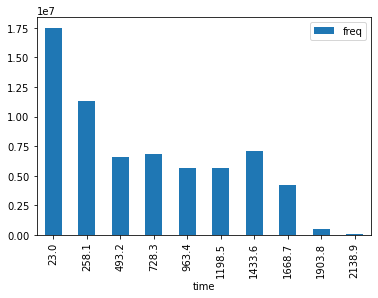

In [31]:
time_dist_df.plot.bar(x='time',y='freq')

From the histogram on 'time', we can see that most players are eliminated at the begining the game. So we focus on the parachuting period.

In [35]:
location = spark.sql("""
             select victim_position_x as X, victim_position_y as Y,time as Time,map as Map from death
             where time<120
             order by time asc
          """).cache()

In [36]:
location.show(10)

+--------+--------+----+-------+
|       X|       Y|Time|    Map|
+--------+--------+----+-------+
|793642.1|20216.34|  23|ERANGEL|
|326611.7|588506.9|  28|ERANGEL|
|463199.8| 6090.61|  32|MIRAMAR|
|180589.4| 7373.03|  33|MIRAMAR|
|528533.3| 8006.34|  33|MIRAMAR|
|132976.3| 8953.52|  33|MIRAMAR|
|170921.9| 7790.76|  34|MIRAMAR|
|239040.5| 6733.71|  34|MIRAMAR|
|521694.0| 7921.38|  34|MIRAMAR|
|148092.8| 8481.53|  34|MIRAMAR|
+--------+--------+----+-------+
only showing top 10 rows



In [37]:
location.count()

3485998

Plot:

In [38]:
location_df=pd.DataFrame(location.collect())

In [39]:
location_df = location_df.rename(columns={0: "X", 1: "Y",2:"Time",3:"Map"})

In [40]:
location_df = location_df.drop("Time",axis=1)

In [41]:
len(location_df)
location_df = location_df.dropna()
len(location_df)

3485998

In [42]:
location_df.head()

,X,Y,Map
0,793642.1,20216.34,ERANGEL
1,326611.7,588506.90,ERANGEL
2,463199.8,6090.61,MIRAMAR
3,180589.4,7373.03,MIRAMAR
4,528533.3,8006.34,MIRAMAR


In [43]:
location_df_er = location_df[location_df["Map"]=="ERANGEL"]
location_df_mi = location_df[location_df["Map"]=="MIRAMAR"]

In [44]:
position = ["X","Y"]
location_df_er = location_df_er[position].apply(lambda x: x* 4096/800000)
location_df_mi = location_df_mi[position].apply(lambda x: x* 1000/800000)
location_df_er = location_df_er[location_df_er[position] != 0]
location_df_mi = location_df_mi[location_df_mi[position] != 0]
location_df_er = location_df_er.dropna()
location_df_mi = location_df_mi.dropna()

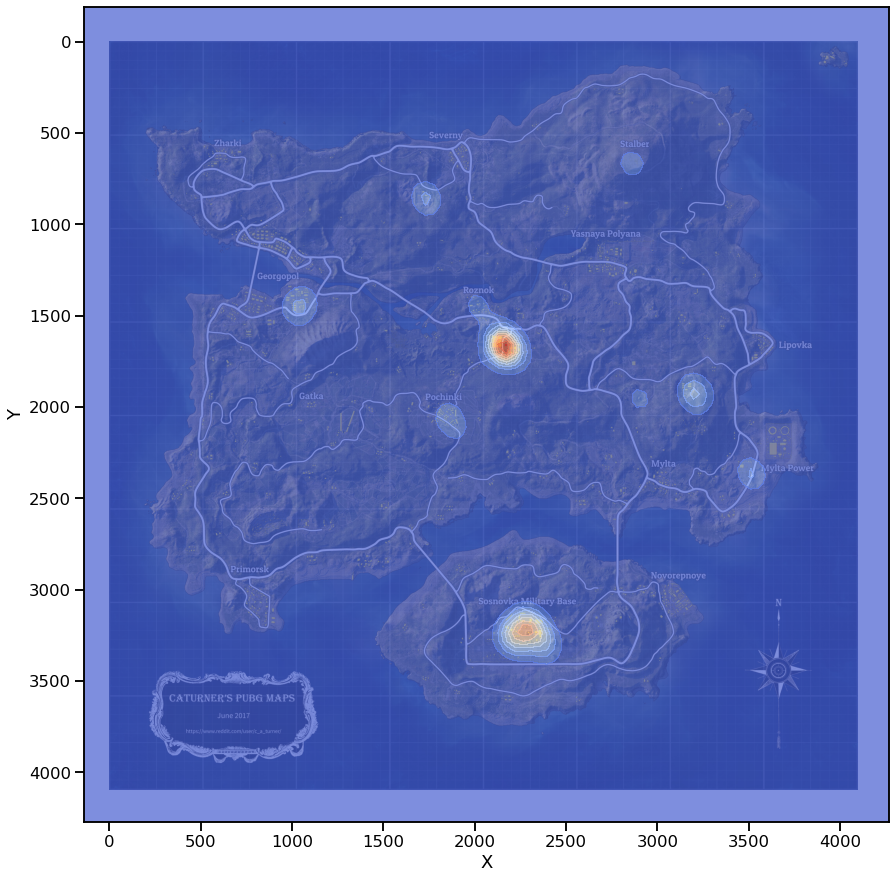

In [45]:
sns.set_context('talk')
bg = imread( "erangel.jpg")
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.imshow(bg)
sns.kdeplot(location_df_er["X"], location_df_er["Y"], cmap="coolwarm", alpha= 0.7, shade=True)

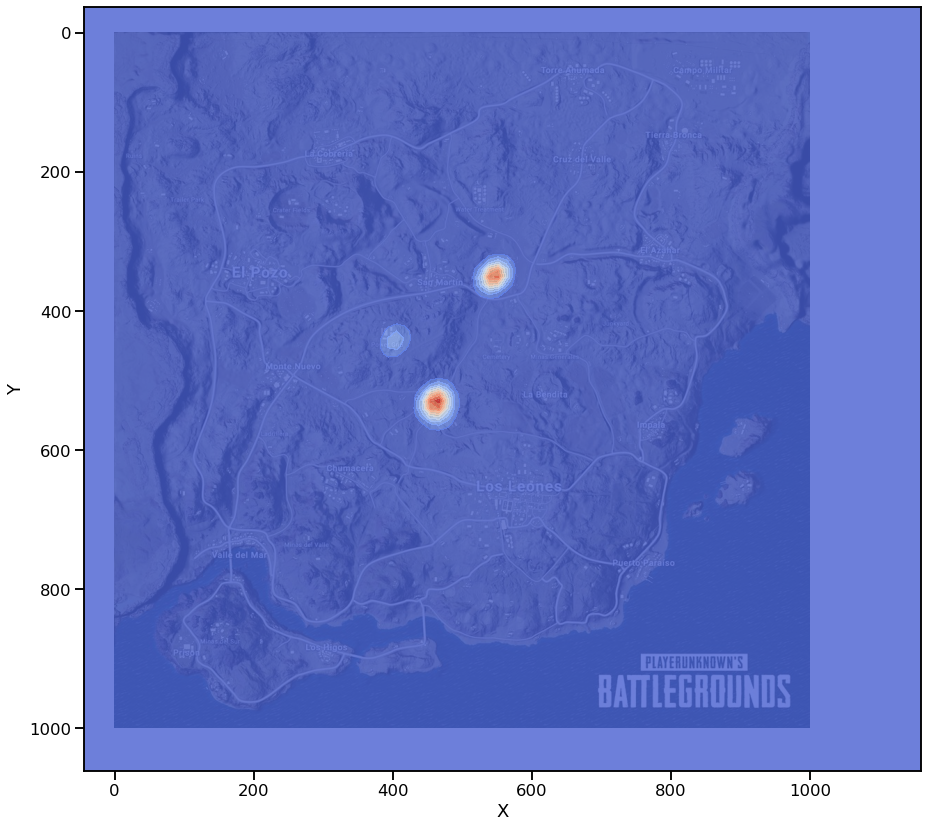

In [46]:
bg = imread( "miramar.jpg")
fig, ax = plt.subplots(1,1,figsize=(15, 15))
ax.imshow(bg)
sns.kdeplot(location_df_mi["X"], location_df_mi["Y"], cmap="coolwarm", alpha= 0.8, shade=True)

##### b. Player's placement vs Number of enemies killed

In [47]:
single.createOrReplaceTempView("single")
double.createOrReplaceTempView("double")  
quadruple.createOrReplaceTempView("quadruple")

Note: due to certain situations, such like quit the game in the midway, some teams have placement = 0.

In [49]:
aggr_all.where(F.col("team_placement") == 0).count()

21

These rows are kept since they are part of the game statistics. Here, we filtered out cases when team_placement = 0.

In [50]:
#Party Size = 1
party1_kill = spark.sql("""
             select team_placement as rank , avg(player_kills) as avg_kills from single
             where team_placement != 0
             group by team_placement
             order by team_placement asc
          """).cache()

In [51]:
party1_kill.show(10)

+----+------------------+
|rank|         avg_kills|
+----+------------------+
|   1| 6.969751310448114|
|   2|3.6002654646288095|
|   3| 3.057091196002367|
|   4|2.7083031778406474|
|   5| 2.471710539314151|
|   6| 2.286021207747616|
|   7| 2.144569085615059|
|   8|2.0153450657220837|
|   9|1.9034249975181177|
|  10|1.8155805183768854|
+----+------------------+
only showing top 10 rows



In [52]:
#Party Size = 2
party2_kill = spark.sql("""
             select team_placement as rank , avg(player_kills) as avg_kills from double
             where team_placement != 0
             group by team_placement
             order by team_placement asc
          """).cache()

In [53]:
party2_kill.show(10) 

+----+------------------+
|rank|         avg_kills|
+----+------------------+
|   1| 4.415817963761304|
|   2|2.5763873716998886|
|   3| 2.231222360345298|
|   4|1.9531180173808915|
|   5|1.7622846411011073|
|   6|1.6204422358082409|
|   7|1.5056336117686697|
|   8|1.4007780133172658|
|   9|  1.32087920357312|
|  10|1.2406817546800781|
+----+------------------+
only showing top 10 rows



In [54]:
#Party Size = 4
party4_kill = spark.sql("""
             select team_placement as rank , avg(player_kills) as avg_kills from quadruple
             where team_placement != 0
             group by team_placement
             order by team_placement asc
          """).cache()

In [55]:
party4_kill.show(10) 

+----+------------------+
|rank|         avg_kills|
+----+------------------+
|   1|2.9363882315012155|
|   2|1.7870165012065466|
|   3|  1.57504738165054|
|   4|1.3729577670316129|
|   5|1.2367563521790572|
|   6| 1.136670386048771|
|   7|1.0511237326041245|
|   8|0.9774791681028356|
|   9|0.9117905572911068|
|  10| 0.853597743215741|
+----+------------------+
only showing top 10 rows



##### c. Kill Distance vs Kill By

In [56]:
distance_kill_by_near = spark.sql("""
             select killed_by as wheapons, avg(power((power((killer_position_x-victim_position_x),2)+power((killer_position_y-victim_position_y),2)),(1/2))) as distance from death
             group by wheapons
             Having distance > 0
             order by distance asc
          """).cache()

In [57]:
distance_kill_by_near.show(10)

+--------------------+------------------+
|            wheapons|          distance|
+--------------------+------------------+
|             RedZone|265.96624028058255|
|               Punch| 274.8840697226602|
|           Motorbike| 293.4156470775891|
|              Sickle|303.02266011079615|
|             Crowbar|312.37976410281607|
|death.ProjMolotov...|312.70611575387886|
|                 Pan| 334.2329013038818|
|             Machete| 358.4467341685376|
| death.ProjMolotov_C|403.49104185821875|
| Motorbike (SideCar)|  480.744140300857|
+--------------------+------------------+
only showing top 10 rows



In [58]:
distance_kill_by_far = spark.sql("""
             select killed_by as wheapons, avg(power((power((killer_position_x-victim_position_x),2)+power((killer_position_y-victim_position_y),2)),(1/2))) as distance from death
             group by wheapons
             Having distance > 0
             order by distance desc
          """).cache()

In [59]:
distance_kill_by_far.show(10)

+------------+------------------+
|    wheapons|          distance|
+------------+------------------+
|         M24|15152.866619321456|
|         AWM|15099.260264442828|
|        Mk14| 13604.54002499796|
|        Boat|13072.815020600916|
|      Kar98k| 12878.87444850381|
|         SKS| 9533.690294314252|
|     Mini 14|  8710.39994713898|
|         Uaz| 6195.537423169284|
|Down and Out| 5925.426339789711|
|         VSS| 5694.080947321124|
+------------+------------------+
only showing top 10 rows



In [60]:
#Create Pandas dataframe to make plot 
distance_kill_by_near_plt = pd.DataFrame(distance_kill_by_near.collect())
distance_kill_by_far_plt = pd.DataFrame(distance_kill_by_far.collect())

d.Kill by wheapons

Wheapons count if player are in first place

In [61]:
wheapons_fir = spark.sql("""
             select killed_by as wheapons, count(killed_by) as count from death
             where victim_placement==2 and killer_placement==1
             group by killed_by
             order by count desc
          """).cache()

In [62]:
wheapons_fir.show(10)

+------------+------+
|    wheapons| count|
+------------+------+
|Down and Out|256428|
|        M416|227924|
|      SCAR-L|163401|
|       M16A4| 83513|
|         AKM| 69078|
|      Kar98k| 50275|
|     Grenade| 43948|
|     Mini 14| 41850|
|         SKS| 28981|
|    Bluezone| 25389|
+------------+------+
only showing top 10 rows



Wheapons count if player rank are between 2 to 10

In [63]:
wheapons_sec_ten = spark.sql("""
             select killed_by as wheapons, count(killed_by) as count from death
             where victim_placement>2 and victim_placement<11
             group by killed_by
             order by count desc
          """).cache()

In [64]:
wheapons_sec_ten.show(10)

+------------+-------+
|    wheapons|  count|
+------------+-------+
|Down and Out|3166089|
|        M416|2002643|
|      SCAR-L|1509078|
|    Bluezone|1110695|
|       M16A4|1055068|
|         AKM| 916838|
|      Kar98k| 606494|
|     Mini 14| 539394|
|         SKS| 409380|
|        UMP9| 404691|
+------------+-------+
only showing top 10 rows



M416 and SCAR-L are the most powerful weapons in the finals. Besides, there are many players eliminated by blue zone.

### (2) Modeling:

#### Linear Regression Model

We want to predict the pencentage of placement for a player given the player's information from the game. Frist, we create a continuous response variable "team_placement_percent" by deviding game_size by team_placement. The variable is between 0 and 1.

In [65]:
aggr_lr = spark.sql("""
             select player_assists, player_dbno, player_dist_ride, player_dist_walk, player_dmg, player_kills, player_survive_time, (team_placement/game_size) as team_placement_percent from aggr
          """).cache()

In [66]:
aggr_lr.show(10)

+--------------+-----------+------------------+------------------+----------+------------+-------------------+----------------------+
|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_survive_time|team_placement_percent|
+--------------+-----------+------------------+------------------+----------+------------+-------------------+----------------------+
|             0|          1|          2870.724|        1784.84778|       117|           1|            1106.32|    0.4864864864864865|
|             0|          1|2938.4072300000003|1756.0797100000002|       127|           1|           1106.315|    0.4864864864864865|
|             0|          0|               0.0|        224.157562|        67|           0|            235.558|    0.8918918918918919|
|             0|          0|               0.0|          92.93515|         0|           0|            197.553|    0.8918918918918919|
|             0|          0|        2619.07739|          2510.

In [67]:
#Check the schema of the dataframe
aggr_lr.printSchema()

root
 |-- player_assists: integer (nullable = true)
 |-- player_dbno: integer (nullable = true)
 |-- player_dist_ride: double (nullable = true)
 |-- player_dist_walk: double (nullable = true)
 |-- player_dmg: integer (nullable = true)
 |-- player_kills: integer (nullable = true)
 |-- player_survive_time: double (nullable = true)
 |-- team_placement_percent: double (nullable = true)



Use a VectorAssembler to put features into a feature vector column, then standardize the column.

In [68]:
# Put features into a feature vector column
lr_vectorAssembler = VectorAssembler(inputCols=aggr_lr.columns[0:7], outputCol="features") 
lr_df_assembled= lr_vectorAssembler.transform(aggr_lr)
# Initialize the `standardscaler`
lr_standardscaler = StandardScaler(inputCol="features", outputCol="features_scaled")
# Fit the DataFrame to the scaler
aggr_lr_scaled = lr_standardscaler.fit(lr_df_assembled).transform(lr_df_assembled)

In [69]:
aggr_lr_scaled.select("features", "features_scaled").show(10, truncate=False)

+------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+
|features                                                          |features_scaled                                                                                                          |
+------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------+
|[0.0,1.0,2870.724,1784.84778,117.0,1.0,1106.32]                   |[0.0,0.8934002410809795,1.4353153509281311,0.4237056871754962,0.6903779656320155,0.6434190716129992,2.125252273355787E-5]|
|[0.0,1.0,2938.4072300000003,1756.0797100000002,127.0,1.0,1106.315]|[0.0,0.8934002410809795,1.469155866080197,0.41687642419595927,0.7493846293612476,0.6434190716129992,2.125242668303572E-5]|
|(7,[3,4,6],[224.157562,67.0,235.558])       

Split the data into training and testing sets.

In [70]:
# Split the data into train and test sets
lr_training, lr_testing = aggr_lr_scaled.randomSplit([.8,.2], seed = 123)

In [71]:
lr_training.columns

['player_assists',
 'player_dbno',
 'player_dist_ride',
 'player_dist_walk',
 'player_dmg',
 'player_kills',
 'player_survive_time',
 'team_placement_percent',
 'features',
 'features_scaled']

GLM: team_rank_percent ~ player_assists + player_dbno + player_dist_ride + player_dist_walk + player_dmg + player_kills + player_survive_time

In [72]:
# Perform linear regression on training set
lr_obj = LinearRegression(
    featuresCol = "features_scaled",
    labelCol = "team_placement_percent",
    predictionCol='pred_team_placement_percent',
    maxIter=10,
    regParam=0.01,
    elasticNetParam=0.8,
    standardization=False)

lr_model = lr_obj.fit(lr_training)

In [73]:
# Print the coefficients and intercept for linear regression
print("Coefficients: %s" % str(lr_model.coefficients))
print("Intercept: %s" % str(lr_model.intercept))

# Summarize the model over the training set and print out some metrics
lr_trainingSummary = lr_model.summary
print("numIterations: %d" % lr_trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(lr_trainingSummary.objectiveHistory))
lr_trainingSummary.residuals.show()
print("Training RMSE: %f" % lr_trainingSummary.rootMeanSquaredError)
print("Training MAE: %f" % lr_trainingSummary.meanAbsoluteError)
print("Training R2: %f" % lr_trainingSummary.r2)

Coefficients: [-0.0260427865498166,0.012899031196966353,-0.11509609249412438,-0.01689372154108172,-0.04731582540839299,-0.03773735324512787,0.0]
Intercept: 0.6507596665205952
numIterations: 11
objectiveHistory: [0.5000000000000002, 0.4661215741366422, 0.3523860487162587, 0.3456385136597178, 0.34364223576143715, 0.3435959947242273, 0.3435795537895101, 0.34357288548320714, 0.3435702971776425, 0.34356972797668917, 0.34356945827091906]
+-------------------+
|          residuals|
+-------------------+
|0.34924033347940475|
|0.34924033347940475|
|0.34924033347940475|
|0.05294403718310847|
|0.34924033347940475|
|0.34924033347940475|
|0.34924033347940475|
|0.34924033347940475|
|0.34924033347940475|
|0.34924033347940475|
|-0.5174263331872619|
|0.34924033347940475|
|0.34924033347940475|
|0.33848764530736175|
|0.34924033347940475|
|0.34924033347940475|
|0.34924033347940475|
| 0.3288321702140986|
|0.34924033347940475|
|0.34924033347940475|
+-------------------+
only showing top 20 rows

Training R

The model does not perform well on training set.

Make predictions.

In [75]:
# Generate predictions
lr_predictions = lr_model.transform(lr_testing)

In [76]:
# Extract the predictions and the "known" correct labels
lr_predandlabels = lr_predictions.select("pred_team_placement_percent", "team_placement_percent")

In [77]:
lr_predandlabels.show(20)

+---------------------------+----------------------+
|pred_team_placement_percent|team_placement_percent|
+---------------------------+----------------------+
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                   1.0|
|         0.6507596665205952|                 

Use the RegressionEvaluator to evaluate model fitting.

In [78]:
lr_evaluator = RegressionEvaluator(predictionCol="pred_team_placement_percent", labelCol="team_placement_percent", metricName="rmse")
print("Testing RMSE: %f" % lr_evaluator.evaluate(lr_predandlabels))

Testing RMSE: 0.234796


In [79]:
lr_evaluator = RegressionEvaluator(predictionCol="pred_team_placement_percent", labelCol="team_placement_percent", metricName="mae")
print("Testing MAE: %f" % lr_evaluator.evaluate(lr_predandlabels))

Testing MAE: 0.191851


In [80]:
lr_evaluator = RegressionEvaluator(predictionCol="pred_team_placement_percent", labelCol="team_placement_percent", metricName="r2")
print("Testing R2: %f" % lr_evaluator.evaluate(lr_predandlabels))

Testing R2: 0.360794


The linear regression model needs to be improved.

#### Logistic Regression

We want to predict whether a player can be placed top 10% given the player's information from the game. Frist, we create a continuous variable "team_placement_percent" by deviding game_size by team_placement. The variable is between 0 and 1. Then we create a binary response variable "team_placement_top10_percent" based on "team_placement_percent". Since we have created "team_placement_percent" in the dataframe "aggr_lr", we can directly employ it.

In [81]:
#Create response variable
aggr_log = aggr_lr.withColumn('team_placement_top10_percent', F.when((F.col("team_placement_percent") <= 0.1), 1) \
                              .otherwise(0)).cache()

In [82]:
#Delete redundant column from the dataframe.
aggr_log = aggr_log.drop("team_placement_percent")

In [83]:
aggr_log.show(20)

+--------------+-----------+------------------+------------------+----------+------------+-------------------+----------------------------+
|player_assists|player_dbno|  player_dist_ride|  player_dist_walk|player_dmg|player_kills|player_survive_time|team_placement_top10_percent|
+--------------+-----------+------------------+------------------+----------+------------+-------------------+----------------------------+
|             0|          1|          2870.724|        1784.84778|       117|           1|            1106.32|                           0|
|             0|          1|2938.4072300000003|1756.0797100000002|       127|           1|           1106.315|                           0|
|             0|          0|               0.0|        224.157562|        67|           0|            235.558|                           0|
|             0|          0|               0.0|          92.93515|         0|           0|            197.553|                           0|
|             0|    

In [84]:
# Put features into a feature vector column
log_vectorAssembler = VectorAssembler(inputCols=aggr_log.columns[0:7], outputCol="features") 
log_df_assembled= log_vectorAssembler.transform(aggr_log)
# Initialize the `standardscaler`
log_standardscaler = StandardScaler(inputCol="features", outputCol="features_scaled")
# Fit the DataFrame to the scaler
aggr_log_scaled = log_standardscaler.fit(log_df_assembled).transform(log_df_assembled)

In [85]:
#Select scaled features and label
aggr_log_scaled = aggr_log_scaled.select("features_scaled","team_placement_top10_percent").cache()

In [86]:
# #Rename the columns
# aggr_log_scaled = aggr_log_scaled.withColumnRenamed("features_scaled", "features")\
#                                  .withColumnRenamed("team_placement_top10_percent", "label").cache()

In [87]:
aggr_log_scaled.show(20, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+----------------------------+
|features_scaled                                                                                                           |team_placement_top10_percent|
+--------------------------------------------------------------------------------------------------------------------------+----------------------------+
|[0.0,0.8934002410809795,1.4353153509281307,0.4237056871754962,0.6903779656320155,0.6434190716129992,2.125252273355787E-5] |0                           |
|[0.0,0.8934002410809795,1.4691558660801967,0.41687642419595927,0.7493846293612476,0.6434190716129992,2.125242668303572E-5]|0                           |
|(7,[3,4,6],[0.05321284812466971,0.39534464698585503,4.5250937794412335E-6])                                               |0                           |
|(7,[3,6],[0.022061910284308848,3.7950137605598367E-6])                     

In [88]:
# Split the data into train and test sets
log_training, log_testing = aggr_log_scaled.randomSplit([.8,.2], seed = 123)

In [89]:
log_training.columns

['features_scaled', 'team_placement_top10_percent']

In [90]:
# Perform logistic regression to make binary classification
log_obj  = LogisticRegression(
    featuresCol = "features_scaled",
    labelCol = "team_placement_top10_percent",
    predictionCol='pred_team_placement_top10_percent',
    maxIter=10,
    regParam=0.01,
    elasticNetParam=0.8,
    standardization=False)
# Fit the model
log_model = log_obj.fit(log_training)

In [91]:
# Print the coefficients and intercepts for logistic regression with binomial family
print("Binomial coefficients: %s" % str(log_model.coefficients))
print("Binomial intercepts: %s" % str(log_model.intercept))

# Summarize the model over the training set and print out some metrics
log_trainingSummary = log_model.summary
print("numIterations: %d" % log_trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(log_trainingSummary.objectiveHistory))
print("Training AUC: %s" % str(log_trainingSummary.areaUnderROC))

Binomial coefficients: [0.25283205698651195,-0.16603486996017996,0.4836256104839159,0.4336197597492136,0.2151837415508833,0.49835220483049053,0.0]
Binomial intercepts: -3.5654042262854517
numIterations: 11
objectiveHistory: [0.29360429733669297, 0.2867534016692594, 0.26967952344963364, 0.2603002842091652, 0.2575215276800176, 0.2433951140791863, 0.24183513808107293, 0.24165812200203607, 0.24153321871916758, 0.24126583014339253, 0.24109674295029215]
Training AUC: 0.8576838340709471


In [92]:
# Generate predictions
log_predictions = log_model.transform(log_testing)

In [93]:
# Extract the predictions and the "known" correct labels
log_predandlabels = log_predictions.select("pred_team_placement_top10_percent", "team_placement_top10_percent")

In [94]:
log_evaluator = BinaryClassificationEvaluator(rawPredictionCol="pred_team_placement_top10_percent",labelCol="team_placement_top10_percent")
print("Testing AUC: %s" % log_evaluator.evaluate(log_predandlabels))

Testing AUC: 0.5785354519778007


In [95]:
log_tp = float(log_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 1").count())
log_fp = float(log_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 0").count())
log_tn = float(log_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 0").count())
log_fn = float(log_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 1").count())
log_pr = log_tp / (log_tp + log_fp)
log_re = log_tp / (log_tp + log_fn)
log_metrics = spark.createDataFrame([
 ("TP", log_tp),
 ("FP", log_fp),
 ("TN", log_tn),
 ("FN", log_fn),
 ("Precision", log_pr),
 ("Recall", log_re),
 ("F1", 2*log_pr*log_re/(log_re+log_pr))],["metric", "value"])
log_metrics.show()

+---------+-------------------+
|   metric|              value|
+---------+-------------------+
|       TP|           191365.0|
|       FP|            99889.0|
|       TN|        1.2194034E7|
|       FN|           967047.0|
|Precision| 0.6570381866000123|
|   Recall|0.16519597517981513|
|       F1| 0.2640125380604912|
+---------+-------------------+



#### Random Forest Classifier

Our goal here is similar to the logistic regression model and decision tree classifier.

In [96]:
#Use the same training and testing sets as logistic regression to perform analysis
rf_training = log_training
rf_testing = log_testing

In [98]:
# Perform random forest classifier to make binary classification
from pyspark.ml.classification import RandomForestClassifier
rf_obj = RandomForestClassifier(featuresCol='features_scaled', labelCol='team_placement_top10_percent', predictionCol='pred_team_placement_top10_percent')
rf_model = rf_obj.fit(rf_training)

In [99]:
#Check feature importances
rf_model.featureImportances

SparseVector(7, {0: 0.0035, 1: 0.0065, 2: 0.0192, 3: 0.1411, 4: 0.0272, 5: 0.044, 6: 0.7585})

In [100]:
# Generate predictions
rf_predictions = rf_model.transform(rf_testing)

In [101]:
# Extract the predictions and the "known" correct labels
rf_predandlabels = rf_predictions.select("pred_team_placement_top10_percent", "team_placement_top10_percent")

In [102]:
rf_evaluator = BinaryClassificationEvaluator(rawPredictionCol="pred_team_placement_top10_percent",labelCol="team_placement_top10_percent")
print("Testing AUC: %s" % rf_evaluator.evaluate(rf_predictions))

Testing AUC: 0.8261671590549542


In [103]:
rf_tp = float(rf_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 1").count())
rf_fp = float(rf_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 0").count())
rf_tn = float(rf_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 0").count())
rf_fn = float(rf_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 1").count())
rf_pr = rf_tp / (rf_tp + rf_fp)
rf_re = rf_tp / (rf_tp + rf_fn)
rf_metrics = spark.createDataFrame([
 ("TP", rf_tp),
 ("FP", rf_fp),
 ("TN", rf_tn),
 ("FN", rf_fn),
 ("Precision", rf_pr),
 ("Recall", rf_re),
 ("F1", 2*rf_pr*rf_re/(rf_re+rf_pr))],["metric", "value"])
rf_metrics.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|          774840.0|
|       FP|          203426.0|
|       TN|       1.2090497E7|
|       FN|          383572.0|
|Precision|0.7920545127807774|
|   Recall| 0.668881192529083|
|       F1|0.7252754041554227|
+---------+------------------+



#### Gradient-Boosted Tree Classifier

Our goal here is similar to the logistic regression model, decision tree classifier, and random forest classifier.

In [104]:
#Use the same training and testing sets as logistic regression to perform analysis
gbt_training = log_training
gbt_testing = log_testing

In [105]:
from pyspark.ml.classification import GBTClassifier
gbt_obj = GBTClassifier(featuresCol ='features_scaled', labelCol = 'team_placement_top10_percent',predictionCol='pred_team_placement_top10_percent',maxIter=10)
gbt_model = gbt_obj.fit(gbt_training)

In [106]:
#Check feature importances
gbt_model.featureImportances

SparseVector(7, {0: 0.0098, 1: 0.0458, 2: 0.001, 3: 0.0079, 4: 0.0016, 5: 0.0651, 6: 0.8688})

In [107]:
# Generate predictions
gbt_predictions = gbt_model.transform(gbt_testing)

In [108]:
# Extract the predictions and the "known" correct labels
gbt_predandlabels = gbt_predictions.select("pred_team_placement_top10_percent", "team_placement_top10_percent")

In [109]:
gbt_evaluator = BinaryClassificationEvaluator(rawPredictionCol="pred_team_placement_top10_percent",labelCol="team_placement_top10_percent")
print("Testing AUC: %s" % rf_evaluator.evaluate(gbt_predictions))

Testing AUC: 0.8252247009170335


In [110]:
gbt_tp = float(gbt_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 1").count())
gbt_fp = float(gbt_predandlabels.filter("pred_team_placement_top10_percent == 1.0 AND team_placement_top10_percent == 0").count())
gbt_tn = float(gbt_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 0").count())
gbt_fn = float(gbt_predandlabels.filter("pred_team_placement_top10_percent == 0.0 AND team_placement_top10_percent == 1").count())
gbt_pr = gbt_tp / (gbt_tp + gbt_fp)
gbt_re = gbt_tp / (gbt_tp + gbt_fn)
gbt_metrics = spark.createDataFrame([
 ("TP", gbt_tp),
 ("FP", gbt_fp),
 ("TN", gbt_tn),
 ("FN", gbt_fn),
 ("Precision", gbt_pr),
 ("Recall", gbt_re),
 ("F1", 2*gbt_pr*gbt_re/(gbt_re+gbt_pr))],["metric", "value"])
gbt_metrics.show()

+---------+------------------+
|   metric|             value|
+---------+------------------+
|       TP|          769469.0|
|       FP|          169598.0|
|       TN|       1.2124325E7|
|       FN|          388943.0|
|Precision|0.8193973379961175|
|   Recall|0.6642446728797698|
|       F1|0.7337084185348219|
+---------+------------------+



### Model Evaluation

For regression, we have tested linear regression with elastic net and regularization parameter. R square equals to 0.360794, which indicates linear regression does not work well. Thus, team_placement dependent variable does not follow linear patterns.

For logistic regression, AUC equals to 0.578535. This indicates that logistic regression does not perform well.

For random forest, AUC equals to 0.826167 and precision equals to 0.792054. This indicates RF classificatoin model performs well. By comparing the variable importance, we found that survive_time of players related closely to team_placement. Thus, the 'camping' strategy could significantly improved the placement.

For Gradient Boosted Tree classifier, AUC equals to 0.82522 and precision equals to 0.81939. This indiactes GBT model performs well, too. For feature importance, we got similar results as random forest model. In GBT model, the survive_time is even more important compared to other features. 

### Stop spark before logging out

In [32]:
spark.stop()